<a href="https://colab.research.google.com/github/Ruthnguli/Twitter-Sentiment-Analysis/blob/main/YellowStone_Remix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading packages

In [ ]:
!pip install snscrape

!pip3 install ktrain

!python -m pip install tensorflow_text

!pip install transformers

     |████████████████████████████████| 25.3 MB 28.9 MB/s 
     |████████████████████████████████| 22.3 MB 1.7 MB/s 
     |████████████████████████████████| 981 kB 45.0 MB/s 
     |████████████████████████████████| 263 kB 30.2 MB/s 
     |████████████████████████████████| 2.8 MB 29.7 MB/s 
     |████████████████████████████████| 1.2 MB 10.8 MB/s 
     |████████████████████████████████| 468 kB 36.2 MB/s 
     |████████████████████████████████| 596 kB 36.0 MB/s 
     |████████████████████████████████| 3.3 MB 23.7 MB/s 
     |████████████████████████████████| 77 kB 6.2 MB/s 
     |████████████████████████████████| 895 kB 33.1 MB/s 
  Created wheel for ktrain: filename=ktrain-0.30.0-py3-none-any.whl size=25309161 sha256=c37154a84ab3f8b4ddc703de0ff9c2edc4d22d12ef2aeda126c67a47feb9de2e
  Stored in directory: /root/.cache/pip/wheels/25/00/ae/80d1b19dd02bc2e6bc9bac32ba7dbaa59aad789e93274e4868
  Created wheel for keras-bert: filename=keras_bert-0.89.0-py3-none-any.whl size=33517 sha256=27a8388b

In [ ]:
# Importing Libraries
#
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import ktrain
from ktrain import text
import tensorflow_hub as hub
import tensorflow_text as text
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib import pyplot as plt
import seaborn as sn
import os
import snscrape.modules.twitter as sntwitter
import re, string
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures
from textblob import TextBlob
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB  
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")

In [ ]:
#Importing lemmatization libraries
import nltk

from nltk.stem.wordnet import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

## Functions

In [ ]:
#function for sorting the multiple hashes and multiple @
#also sorts out @'s and # that occur within text
# changes lonesome @ to at
def find_the (text):
    while len(re.findall('##' , text)) != 0:
        text = re.sub('##' , '#' ,text)
    while len(re.findall('@@' , text)) != 0:
        text = re.sub('@@' , '@' ,text)

    no_h = len(re.findall('#',text))
    #make sure the @ is changed for at
    no_a = len(re.findall('@',text))
    
    text = re.sub('@(\s|\.|\?|,|;|:|!|\(|\))', 'at' , text)
    text = re.sub('\s' , ' ' , text)
    text = re.sub('\S@' , ' @' , text)
    text = re.sub('\S#' , ' #' , text)

    #while len(re.findall('\s\s' , text)) != 0:
    #    text = re.sub('\s\s' , '\s' ,text)

    #none_repeat = text
    text_a = text.split()

            
    return text

In [ ]:
# Applying Lemmmatizer to remove tenses from texts.
lemmatizer = WordNetLemmatizer()
#stemmer = SnowballStemmer("english")
STOPWORDS.update(['mkr', 'didn', 'bc', 'n', 'm', 
                  'im', 'll', 'y', 've', 'u', 'ur', 'don', 
                  'p', 't', 's', 'aren', 'kp', 'o', 'kat', 
                  'de', 're', 'amp', 'will'])# 'rt'
corpus = []
def preprocess_tweet(tweet):
    tweet = re.sub(r"won\'t", "will not", tweet)
    tweet = re.sub(r"can\'t", "can not", tweet)
    tweet = re.sub(r"n\'t", " not", tweet)
    tweet = re.sub(r"\'re", " are", tweet)
    tweet = re.sub(r"\'s", " is", tweet)
    tweet = re.sub(r"\'d", " would",tweet)
    tweet = re.sub(r"\'ll", " will", tweet)
    tweet = re.sub(r"\'t", " not", tweet)
    tweet = re.sub(r"\'ve", " have", tweet)
    tweet = re.sub(r"\'m", " am", tweet)
    #tweet = re.sub('[^a-zA-Z]',' ',tweet)
    #tweet = re.sub(r'[^\x00-\x7f]','',tweet)
    #tweet = " ".join([stemmer.stem(word) for word in tweet.split()])
    tweet = [lemmatizer.lemmatize(word) for word in tweet.split() if not word in set(STOPWORDS)]
    tweet = ' '.join(tweet)
    return tweet

In [ ]:
# Creating a tag maker function to extract @'s and #'s as the data is cleaned by the lemmatizer so as not to alter the tags
def tag_maker (text):
  text_a = text.split()
  tag_a = []
  for r in range(0, len(text_a)):
    if text_a[r].startswith('#') or text_a[r].startswith('@'):
      tag_name = '<<yellowstone<<' + str(len(tag_a)) + '>>yellowstone>>'
      tag_a.append(text_a[r])
      text_a[r] = tag_name

  r_text = ' '.join(text_a)

  return [r_text , tag_a]

  

In [ ]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']


In [ ]:
# Creating a tag replacer function replaces tags from text that has been lematized to the original @'s and #'s


def tag_replacer (text , tag_a):
  text_a = text.split()

  for r in range(0, len(text_a)):
    if ('<<yellowstone<<' in text_a[r]) and ('>>yellowstone>>' in text_a[r]):
      num = text_a[r]
      num = num[15:][:-15]
      num = int(num)
      text_a[r] = tag_a[num]

  r_text = ' '.join(text_a)

  return r_text

In [ ]:
# Creating a lema and stem function to call the tag maker the lematizer and the tag replacer

def tags_lema_stem(text):
  for_lem = tag_maker(text)
  for_tag_removal = preprocess_tweet(for_lem[0])
  r_text = tag_replacer(for_tag_removal, for_lem[1])

  return r_text

In [ ]:
# fuction to get the ats and hashes out 

def hash_and_ats (text):
    text_a = text.split()
    hash_list = []
    at_list = []
    
    for a in text_a:
        
        if a.startswith('#'):
            a = a.lower()
            hash_list.append(a)
        elif a.startswith('@'):
            at_list.append(a)

    return [hash_list , at_list]

In [ ]:
# removes words that start with at predefined set of characters in a list
def header_remover(text, hr):
    to_drop = hr
    text_a = text.split()
    for g in range(len(text_a)-1, -1 , -1):
        for a in to_drop:
            if text_a[g].startswith(a):
                text_a.pop(g)
                break

    text = ' '.join(text_a)
    return text

In [ ]:
# Polarity
# Function to get polarity(sentiments) of text using the module textblob
#
def get_polarity(text):
    try:
        textblob = TextBlob(text)
        pol = textblob.sentiment.polarity
    except:
        pol = 0.0
    return pol

In [ ]:
# Subjectivity
# Function to get polatiy of text using the module textblob
def get_subjectivity(text):
    try:
        textblob = TextBlob(text)
        subj = textblob.sentiment.subjectivity
    except:
        subj = 0.0
    return subj

In [ ]:
# Labelling sentiments to either Positive or Negative
#
def positive_negative(f):
	if f < 0:
		return 'Negative'
	else:
		return 'Positive'

In [ ]:
#Visiualization function
#
def bar_outlier (stat_dataframe, threshold):
  sec = stat_dataframe.iloc[1,1]
  fir = stat_dataframe.iloc[0,1]
  if threshold != 0:
    if fir > (sec * threshold):
      stat_dataframe = stat_dataframe.drop(stat_dataframe.index[0])
      stat_dataframe.reset_index(inplace=True)
      stat_dataframe.drop(columns = ['index'] , inplace = True)
  return stat_dataframe

#Visiualization function
#
def make_bars(h_list , entries, f_size, threshold):
  c = collections.Counter(sum(h_list, []))
  hash = pd.DataFrame(c.most_common(entries))
  hash = bar_outlier(hash , threshold)
  fig = plt.figure(figsize = f_size)
  ax = fig.add_axes([0,0,1,1])
  ax.bar(hash[0],hash[1])
  plt.xticks(rotation=60)

In [ ]:
# creating a def function to identify hastags and ats for visualization
#
def for_pie (a,b):
  if a == [] and b == []:
    return 0
  if a == [] and b != []:
    return 1
  if a != [] and b == []:
    return 2
  if a != [] and b != []:
    return 3

# Business Understanding

# Data Understanding

## Data Acquisition

In [ ]:
# Creating list to append tweet data to
tweets_list2 = []

# Using TwitterSearchScraper to scrape data and append tweets to list
for i,tweet in enumerate(sntwitter.TwitterSearchScraper('EABL').get_items()):
    if i>5000:
        break
    tweets_list2.append([tweet.date, tweet.id, tweet.content, tweet.username])
    
# Creating a dataframe from the tweets list above
tweets_df2 = pd.DataFrame(tweets_list2, columns=['Datetime', 'Tweet Id', 'Tweet', 'Username'])

In [ ]:
# Previewing the top 20 of data
#
tweets_df2.head(20)

In [ ]:
# Preview the shape of data
#
tweets_df2.shape

In [ ]:
# preview of 20 random samples
#
tweets_df2.sample(10)

## .........

# Data Preparation

## Cleaning Data

In [ ]:
# dropping irrelevant columns
df = tweets_df2.drop(['Datetime', 'Tweet Id', 'Username'], axis = 1) 

# renaming column 
df.columns = ['tweet']

# previewing datset
df.sample(5)

In [ ]:
# getting non repetitive column
# handling whitespaces
df['nr_tweet'] = df.tweet.apply(lambda d: find_the(d))
df.head()

In [ ]:
# We take the non repetitive tweets and change them to lower case, expose them to the tags_lema_stem 
# as well as, removing the (not so sure) while still maintaining the hashtags and ats



df['c_tweet'] = df['nr_tweet'].str.lower()

df['c_tweet'] = df['c_tweet'].apply (lambda i : tags_lema_stem(i))

df['c_tweet'] = df['c_tweet'].apply(lambda i : re.sub('[^a-zA-Z0-9_#@ ]','',i)) #maintains the hashtags and the @'s

df.head(20)

In [ ]:
# getting the hashtag and ats columns
#
df['hashtags'] = df['nr_tweet'].apply(lambda f : hash_and_ats(f)[0])
df['ats'] = df['nr_tweet'].apply(lambda f : hash_and_ats(f)[1])

# preview of random 20 
#
df.sample(2)

In [ ]:
# Removing the hash and Ats

df['m_tweet'] = df['c_tweet'].apply(lambda i : header_remover(i , ['#' , '@']))
df['h_tweet'] = df['c_tweet'].apply(lambda i : header_remover(i , ['@']))
df['a_tweet'] = df['c_tweet'].apply(lambda i : header_remover(i , ['#']))

In [ ]:
# the rest of the stats
df['no_of_punctuations'] = df.tweet.apply(lambda x : len(re.findall('[^a-zA-Z0-9_ ]', x)))
df['no_of_at'] = df['ats'].apply ( lambda s : len(s))
df['no_of_hashes'] = df['ats'].apply ( lambda s : len(s))
df['no_of_words'] = df['nr_tweet'].apply ( lambda s : len(s.split()))

# no of words without @
df['no_of_words_no_at'] = df['no_of_words'] - df['no_of_at']

# no of words without #
df['no_of_words_no_hash'] = df['no_of_words'] - df['no_of_hashes']

# no of words without @ and #
df['no_of_words_no_at_hash'] = df['no_of_words'] - df['no_of_at'] - df['no_of_hashes']
df['length_of_tweet'] = df['nr_tweet'].apply (lambda y : len(y))


In [ ]:
# Viewing our current dataset

df.head(20)

## ****Testing for digits

In [ ]:
# contains a list of the beginning of the words that should be dropped
#
header_drop = ['http']

In [ ]:
# Finding the number of digits contained in the tweet
#
df['is_there_digit'] = df['m_tweet'].apply(lambda y : len(re.findall('[0-9]' , y)))

In [ ]:
# Getting the all the digits that are not 0

m = df[(df['is_there_digit'] != 0)]

In [ ]:
# removing the http from the m

m['m_tweet'] = m['m_tweet'].apply(lambda r : header_remover(r, ['http']))

In [ ]:
m['is_there_digit'] = m['m_tweet'].apply(lambda y : len(re.findall('[0-9]' , y)))

In [ ]:
m[(m['is_there_digit'] != 0)]

In [ ]:
# Previewing our current dataset

df.head(20)

## Duplicated Data

In [ ]:
#delete the duplicates by dropping them and store the result value to a new variable

df2 = df.drop_duplicates('m_tweet',keep='first') 

df2.head(30)

In [ ]:
# we dropped duplicated rows

print(df.shape)
print(df2.shape)

In [ ]:
# checking white space
print(df2.m_tweet.str.isspace())

print('\n')
print('Number of spaces', df2.m_tweet.str.isspace().sum())

In [ ]:
# getting data without whitespaces

df_clean = df2[df2['m_tweet'] != '']
df_clean.head()

# EDA

## Visualizations

### Hashtags

In [ ]:
# Visualizing most commonly used hashtags
#
h_df = df_clean['hashtags'].apply(lambda f : ' '.join(f))

In [ ]:
# Mostly used hashtags in a word cloud
#
plt.figure(figsize=(20,20))
wc2 = WordCloud(max_words=2000, min_font_size=10, height=800, width=1600, 
        background_color="#ffffff").generate(" ".join(h_df))
plt.imshow(wc2)
plt.axis('off')
plt.title('Commonly used Hashtags', fontsize=50)
plt.tight_layout(pad=0)
plt.show()



In [ ]:
# Getting frequencies of hashtags
#
h_list = df_clean['hashtags'].to_list()
import collections
c = collections.Counter(sum(h_list, []))
hash = pd.DataFrame(c.most_common(20))
hash = bar_outlier(hash,1.5)

In [ ]:
# A bar plot of used hashtags
#

fig = plt.figure(figsize=(15,15))
ax = fig.add_axes([0,0,1,1])
ax.bar(hash[0],hash[1])
plt.xticks(rotation=60)
plt.show()

### Mentions

In [ ]:
# Visualizing @s on a wordcloud
#
a_df = df_clean['ats'].apply(lambda f : ' '.join(f))

In [ ]:
# Word cloud 
#
plt.figure(figsize=(20,20))
wc2 = WordCloud(max_words=2000, min_font_size=10, height=800, width=1600, 
        background_color="white").generate(" ".join(a_df))
plt.imshow(wc2)


In [ ]:
# A visualization of most @s
#
make_bars(df_clean['ats'].to_list(), 15, (15,15), 1.5)

### Most Common words in tweet

In [ ]:
w_df = df_clean['m_tweet']

# Plotting most common words in a WordCloud
#
plt.figure(figsize=(20,20))
wc2 = WordCloud(max_words=2000, min_font_size=10, height=800, width=1600, 
        background_color="white").generate(" ".join(w_df))
plt.imshow(wc2)

In [ ]:
# splitting the m_tweet to individual words

w_df = df_clean['m_tweet'].apply(lambda a : a.split()).to_list()


In [ ]:
# Visualizing most common words in a bar plot
#
make_bars(w_df , 15, (15,15), 1.5)

### Pie Chart of Hashtags & Mentions

In [ ]:
df_clean['pie'] = df_clean.apply(lambda r : for_pie(r['hashtags'], r['ats']) , axis = 1)

# Checking to see the key and value of each assigned number ie 0, 1, 2, 3

pie = collections.Counter(df_clean['pie'].to_list())
pie

In [ ]:
# Getting the values 
pie.values()

In [ ]:
# Visualizing hastags and ats in a pie chart
#
labels= ['hash & Ats', 'hash no Ats', 'no hash w Ats', 'no hash or Ats']

colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']

sizes= [984, 2667, 466, 604]

plt.figure(figsize =(8, 8))
plt.pie(sizes,labels=labels, colors=colors, startangle=90, shadow=True,explode=(0.1, 0.0, 0.0, 0.0), autopct='%1.2f%%')

plt.title('Haashtags & Ats Pie Chart')

plt.axis('equal')
plt.legend(loc="lower right")
plt.show()

### Word Count

In [ ]:
# A histigrom of no of words 
#
plt.figure(figsize =(10, 6))
df_clean['no_of_words'].hist()
plt.title("A Histogram of Word Count")
plt.xlabel("Word Count")
plt.show();

### Length of Tweet

In [ ]:
# A histogram to show distribution of tweet length
#
plt.figure(figsize =(10, 6))
df_clean['length_of_tweet'].hist()
plt.title("A Histogram of Tweet Length")
plt.xlabel("Length of Tweet")
plt.show();


## Sentiment Analysis

In [ ]:
# Polarity

df_clean['polarity'] = df_clean['nr_tweet'].apply(lambda x :get_polarity(x))
df_clean[['nr_tweet', 'polarity']].sample(10)

In [ ]:
# Subjectivity

df_clean['subjectivity'] = df_clean.tweet.apply(get_subjectivity)
df_clean[['tweet', 'subjectivity']].sample(10)

In [ ]:
# Extracting sentiments score
#
df_clean['sentiment_score'] = df_clean['tweet'].apply(lambda x: TextBlob(x).sentiment[0])
df_clean[['tweet', 'polarity', 'subjectivity', 'sentiment_score']].sample(10)


In [ ]:
# Labelling sentiments to either Positive or Negative
#

df_clean['sentiment'] = df_clean.apply(lambda r : positive_negative(r['sentiment_score']) , axis = 1)
df_clean[['tweet', 'polarity', 'subjectivity', 'sentiment_score', 'sentiment']].sample(10)


### Scatter plot of Polarity & Subjectivity

In [ ]:
# plotting the line-chart for the average polarity with the supply-chain-incidents
plt.figure(figsize =(10, 8))
plt.title("polarity vs subjectivity")
plt.xlabel("polarity")
plt.ylabel("subjectivity")
plt.ylim(-0.3, 0.3)
plt.scatter(df_clean['polarity'],	df_clean['subjectivity'])
plt.show();


In [ ]:
# a plot of sentiments 
#
import seaborn as sns

plt.figure(figsize =(8, 6))
sns.countplot(data=df_clean, x= 'sentiment') 
plt.title("A Bar Plot of sentiments")
plt.show();


In [ ]:
# Frequency distributions of the sentiment categories
#
df_clean[['m_tweet', 'sentiment']].groupby('sentiment').describe()

# BERT............

In [ ]:
# build our model with the Sequence Classifier and our tokenizer with BERT’s Tokenizer.
#
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [ ]:
# Looking at the summary of our model
#
model.summary()

In [ ]:
# Getting the dataset
#
dataset = df_clean.copy()
dataset['sentiment']

In [ ]:
# Creating instance of labelencoder
#

labelencoder = LabelEncoder()

# Assigning numerical values and storing in another column
dataset['sentiment_Cat'] = labelencoder.fit_transform(dataset['sentiment'])
dataset.head()

# Modelling

## Class Imbalance

In [ ]:
# Performing oversampling to deal with our class imbalance 
# This is because undersampling requires a large number of records which we don't have in our case

# Let's start by seeing the shape of our classes
positive = dataset[dataset['sentiment_Cat']==1]
negative = dataset[dataset['sentiment_Cat']==0]

print(positive.shape,negative.shape)

(3971, 23) (665, 23)


In [ ]:
# Splitting our dataset into dependent and independent variables

X = dataset['m_tweet'].values.reshape(-1, 1)
y = dataset['sentiment_Cat'].values.reshape(-1, 1)

print(X.shape, y.shape)

(4636, 1) (4636, 1)


In [ ]:
# Performing oversampling
from imblearn.over_sampling import RandomOverSampler
os = RandomOverSampler(sampling_strategy=0.5)
X_res, y_res = os.fit_resample(X,y)

In [ ]:
# The new shape of our X and y variables
print(X_res.shape,y_res.shape)

(5956, 1) (5956,)


In [ ]:
# Checking for the imbalance of the sentiment columns

dataset['sentiment_Cat'].value_counts()

1    3971
0     665
Name: sentiment_Cat, dtype: int64

In [ ]:
# Checking to see that we corrected the imbalance

np.unique(y_res, return_counts=True)

(array([0, 1]), array([1985, 3971]))

In [ ]:
# Splitting
#
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

In [ ]:
# Having a preview of four random tweets
X_train

array([['fair professions many similar case kra even diminished manufacturing capacity eabl still cases celebrating them ends'],
       ['leather boots rubber soles ksh 5000 sizes 3945 0729317944 4 orders bihi tower 5th flr rm 3 we deliver countrywide keroche white house tabitha kipkoech makueni kcse eabl httpstcotcijg0vu0j'],
       ['nexus bistro lounge kisii hosting something big courtesy eabl there entry free httpstcoratdtccjml'],
       ...,
       ['business hate defined benefit pensions really it'],
       ['hello enquiring long one received keg pump applying it applied mine 2019 nakuru depot upto date received'],
       ['eabl keep big bag marketing spending tusker fc draw line keep recycling way sell notruly kenyan brand kpl club named flagship beer 3 fan cant even chat attendance beloved zoo kericho']],
      dtype=object)

In [ ]:
# Importing the BERT model and get embeding vectors for few sample statements
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

INFO:absl:Using /tmp/tfhub_modules to cache modules.
INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'.
INFO:absl:Downloaded https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3, Total size: 1.96MB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'.
INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'.
INFO:absl:Downloaded https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4, Total size: 429.66MB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'.


In [ ]:
# Get embeding vectors for few sample words. Compare them using cosine similarity
e = get_sentence_embeding([
    "bread", 
    "grapes",
    "mango",
    "Jasmine Wakini",
    "Ruth Nguli",
    "Billiah Kerubo"
]
)

In [ ]:
cosine_similarity([e[0]],[e[1]])

array([[0.9748135]], dtype=float32)

In [ ]:
cosine_similarity([e[3]],[e[4]])

array([[0.85866576]], dtype=float32)

In [ ]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [ ]:
# The summary of our BERT model:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [ ]:
# Length of X_train and X_test
print(len(X_train))
print(len(X_test))

4764
1192


In [ ]:
# Obtaining the metrics needed for our assessment
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [ ]:
# Training the model
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
149/149 [==============================] - 116s 683ms/step - loss: 0.6196 - accuracy: 0.6616 - precision: 0.6760 - recall: 0.9505
Epoch 2/10
149/149 [==============================] - 101s 677ms/step - loss: 0.6027 - accuracy: 0.6692 - precision: 0.6836 - recall: 0.9424
Epoch 3/10
149/149 [==============================] - 101s 676ms/step - loss: 0.5929 - accuracy: 0.6832 - precision: 0.7007 - recall: 0.9204
Epoch 4/10
149/149 [==============================] - 101s 680ms/step - loss: 0.5878 - accuracy: 0.6803 - precision: 0.7001 - recall: 0.9148
Epoch 5/10
149/149 [==============================] - 101s 676ms/step - loss: 0.5853 - accuracy: 0.6767 - precision: 0.6982 - recall: 0.9117
Epoch 6/10
149/149 [==============================] - 101s 676ms/step - loss: 0.5841 - accuracy: 0.6851 - precision: 0.7069 - recall: 0.9054
Epoch 7/10
149/149 [==============================] - 100s 674ms/step - loss: 0.5790 - accuracy: 0.6805 - precision: 0.7042 - recall: 0.9023
Epoch 8/10
14

In [ ]:
# Model evaluation
model.evaluate(X_test, y_test)

38/38 [==============================] - 26s 665ms/step - loss: 0.5796 - accuracy: 0.7013 - precision: 0.7229 - recall: 0.8806


[0.5796478390693665,
 0.7013422846794128,
 0.7228661775588989,
 0.8806161880493164]

In [ ]:
# Prediction
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([0, 1, 1, ..., 1, 1, 1])

In [ ]:
# Confusion matrx
cm = confusion_matrix(y_test, y_predicted)
cm

array([[150, 263],
       [ 93, 686]])

Text(69.58333333333334, 0.5, 'Truth')

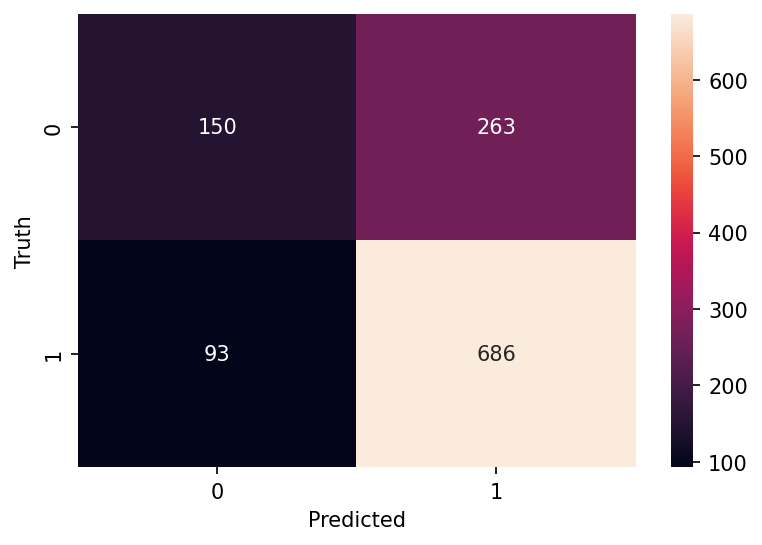

In [ ]:
# Visualizing the confusion matrix

plt.figure(dpi=150)
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
# Classification report
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.62      0.36      0.46       413
           1       0.72      0.88      0.79       779

    accuracy                           0.70      1192
   macro avg       0.67      0.62      0.63      1192
weighted avg       0.69      0.70      0.68      1192



In [ ]:
# Inference
sentiments = [
    "april kengen dividend may equity dividend june dtb dividend december eabl dividend etc etc 30 company giving dividend 12 months roughly 2 company give dividend per month", 
    "congratulations randolph worthy battle well fought"]
model.predict(sentiments)

array([[0.506347 ],
       [0.7303566]], dtype=float32)

## Challenging the Solution

### Naive Bayes

In [ ]:
# Finally, we will transform the data into occurrences, 
# which will be the features that we will feed into our model
# 

from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(ngram_range=(1,2))    # Unigram and Bigram
counts = count_vectorizer.fit_transform(dataset['m_tweet'])  
counts

<4636x56006 sparse matrix of type '<class 'numpy.int64'>'
	with 107175 stored elements in Compressed Sparse Row format>

In [ ]:
# We could leave it as the simple word-count per message, but it is better to use Term Frequency Inverse Document Frequency, more known as tf-idf
# 
from sklearn.feature_extraction.text import TfidfTransformer

transformer = TfidfTransformer().fit(counts)

counts_tfid = transformer.transform(counts)

In [ ]:
from sklearn.feature_extraction.text import Tfid

ImportError: ignored

In [ ]:
# Training the Model
# Now that we have performed feature extraction from our data, it is time to build our model. 
# We will start by splitting our data into training and test sets
# 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(counts.toarray(), dataset['sentiment_Cat'], test_size=0.1, random_state=69)

In [ ]:
# Printing splitted dataset sizes
print("X_train_shape : ",X_train.shape)
print("X_test_shape : ",X_test.shape)
print("y_train_shape : ",y_train.shape)
print("y_test_shape : ",y_test.shape)

X_train_shape :  (4172, 56006)
X_test_shape :  (464, 56006)
y_train_shape :  (4172,)
y_test_shape :  (464,)


In [ ]:
# We will use Multinomial Naive Bayes classifier
from sklearn.naive_bayes import MultinomialNB  # Naive Bayes Classifier

model_naive = MultinomialNB().fit(X_train, y_train) 
predicted_naive = model_naive.predict(X_test)
print(np.mean(predicted_naive == y_test))

0.7586206896551724


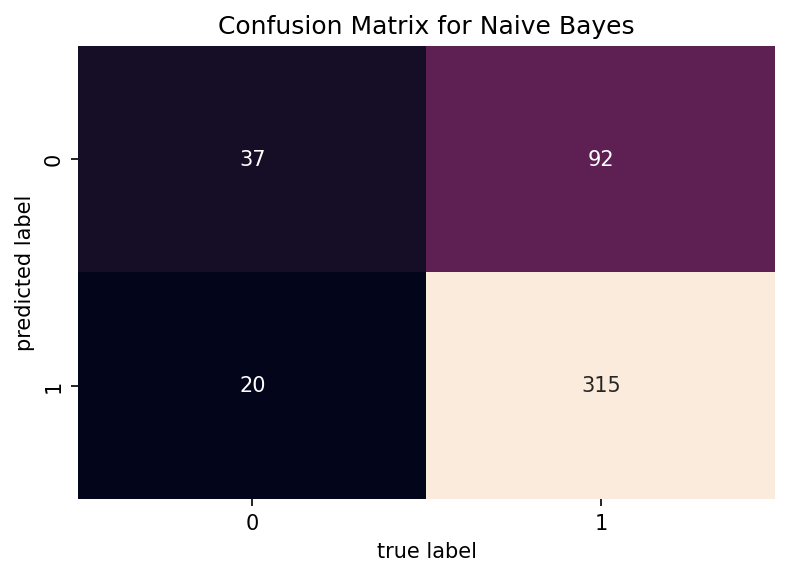

In [ ]:
# Print Confusion matrix
from sklearn.metrics import confusion_matrix

plt.figure(dpi=150)
mat = confusion_matrix(y_test, predicted_naive)
sns.heatmap(mat.T, annot=True, fmt='d', cbar=False)

plt.title('Confusion Matrix for Naive Bayes')
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

In [ ]:
# Find out accuracy of our prediction
from sklearn.metrics import accuracy_score

score_naive = accuracy_score(predicted_naive, y_test)
print("Accuracy with Naive-bayes: ",score_naive)


Accuracy with Naive-bayes:  0.7586206896551724


In [ ]:
# Classification report
print(classification_report(y_test,predicted_naive ))

              precision    recall  f1-score   support

           0       0.29      0.65      0.40        57
           1       0.94      0.77      0.85       407

    accuracy                           0.76       464
   macro avg       0.61      0.71      0.62       464
weighted avg       0.86      0.76      0.79       464

